<a href="https://colab.research.google.com/github/xihengjing/Colab-Notebooks/blob/main/Searching%20Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What I would like to develope is a search engine with recommender function in which the user would be able to search for certain types of venues in the Bournemouth area based on the categories, the system will then return the nearest venues under the same category to the user. The original dataset has the following variables: the names of the venues, the categoies, the longitudes, and the latitudes. The final model will group the venues based on their relative distances and the higher level categories.

Data Source: [Kaggle](https://www.kaggle.com/purvank/uber-rider-reviews-dataset/data) by user *Power*

In [ ]:
#Importing the necessary modules
import requests
import os
import pandas as pd
import seaborn as sns
import numpy as np
import folium
import random
from random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import math
%matplotlib inline



In [ ]:
BOURNEMOUTH = (50.721680, -1.878530) #this is our pointer for the city Bournemouth
ZOOM = 15 #this is the default opening zoom parameter for the map

#we define the constants that we are going to use in this project for ease of reference
COL_LAT = 'Latitude'
COL_LNG = 'Longitude'
COL_VENUE_NAME = 'Venue Name'
COL_VENUE_LAT = 'Venue Latitude'
COL_VENUE_LNG = 'Venue Longitude'
COL_VENUE_CAT = 'Venue Category'
COL_VENUE_GRP = 'Venue Group'
COL_VENUE_CLS = 'Venue Cluster'

DRINK = 'Drink'
ENTERTAINMENT = 'Entertainment'
FOOD = 'Food'
HOTEL = 'Hotel'
SHOPPING = 'Shopping'
TRANSPORT = 'Transport'
DESSERT = 'Dessert'



In [ ]:
#importing data

url = 'https://raw.githubusercontent.com/xihengjing/xjing/master/bournemouth_venues.csv'

# Load data into a pandas dataframe

df = pd.read_csv(url)

# Print first 5 rows of the dataframe
df.head()

,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,South Coast Roast,Coffee Shop,50.720913,-1.879085
1,DelMarco,Italian Restaurant,50.721370,-1.877221
2,Lower Gardens,Park,50.719323,-1.878195
3,Bournemouth Gardens,Park,50.718990,-1.877733
4,Bournemouth Square,Plaza,50.720156,-1.879563


We are going to define our own function for creating the map using folium module.

In [ ]:
def generate_map(df, lat, lng, zoom, col_lat, col_lng,
                 col_popup=None, popup_colors=False, def_color='red',
                 tiles='cartodbpositron'):
    #we are setting up the center of the map using coordinates of Bournemouth and also the look of the map background
    folmap = folium.Map(location=[lat, lng], zoom_start=zoom, tiles=tiles) 
    
    popup = list(df[col_popup].unique())#assigning information to each of the point on the map
    
    if popup_colors:
        colors = make_color_palette(len(popup))#we will define this function in next block
    
    #defining the coordinates, color, and parameters of each point on the map
    for index, row in df.iterrows():
        folium.CircleMarker(
            location=(row[col_lat], row[col_lng]),
            radius=6,
            popup=row[col_popup] if col_popup is not None else '',
            fill=True,
            color=colors[popup.index(row[col_popup])] if popup_colors else def_color,
            fill_opacity=0.6
            ).add_to(folmap)
    
    return folmap

In [ ]:
#building our list of colors 
def make_color_palette(size, n_min=50, n_max=205):
    r = lambda: hex(randint(0, 255))[2:]
    colors = []
    
    while len(colors) < size:
        c = '#{}{}{}'.format(r(), r(), r())
        
        if c not in colors:
            colors.append(c)
    
    return colors

All of the 100 venues are plotted on the map as follows, clicking on each point will show the name of the venue.

In [ ]:
generate_map(df, BOURNEMOUTH[0], BOURNEMOUTH[1], ZOOM, COL_VENUE_LAT, COL_VENUE_LNG, col_popup=COL_VENUE_NAME)

Next, we are going to check how many categories are there for these venues

In [ ]:
venue_cat = df[COL_VENUE_CAT].unique()
venue_cat.sort()

print('Venue count:', len(venue_cat))
venue_cat

Venue count: 51


array(['Aquarium', 'Art Museum', 'Arts & Entertainment', 'Bar', 'Beach',
       'Brewery', 'Bubble Tea Shop', 'Burger Joint', 'Bus Stop', 'Café',
       'Caribbean Restaurant', 'Chinese Restaurant', 'Clothing Store',
       'Cocktail Bar', 'Coffee Shop', 'Comfort Food Restaurant',
       'Dessert Shop', 'Diner', 'English Restaurant',
       'Fast Food Restaurant', 'French Restaurant', 'Garden', 'Gay Bar',
       'Greek Restaurant', 'Grocery Store', 'Gym', 'Gym / Fitness Center',
       'Hotel', 'Ice Cream Shop', 'Indian Restaurant',
       'Italian Restaurant', 'Mexican Restaurant',
       'Modern European Restaurant', 'Multiplex', 'Nightclub',
       'Noodle House', 'Other Great Outdoors', 'Park', 'Pizza Place',
       'Platform', 'Plaza', 'Pub', 'Sandwich Place', 'Scenic Lookout',
       'Seafood Restaurant', 'Tapas Restaurant', 'Thai Restaurant',
       'Theater', 'Train Station', 'Turkish Restaurant',
       'Vegetarian / Vegan Restaurant'], dtype=object)

There are way more categories than we need, so we are going to clean up the categories and group these venues into 7 higher categories.

In [ ]:
#defining function for transforming the categories, we use the df.loc method to first set condition then assign each venue
#to the new category under column we created earlier
def change_group(df, grp_from_list, grp_to):
    for grp_from in grp_from_list:
        df.loc[df[COL_VENUE_GRP] == grp_from, COL_VENUE_GRP] = grp_to

In [ ]:
# Quickly set venue groups to the last word in each venue category
df[COL_VENUE_GRP] = df[COL_VENUE_CAT].str.split(' ').str[-1]

# Remove the train station platform venue because we already have the nearby train station as a venue
df = df[df[COL_VENUE_GRP] != 'Platform']

# Change the crude, last-word groups into more high-level groups
change_group(df,
             ['Bar', 'Brewery', 'Nightclub', 'Pub'],
             DRINK)

change_group(df,
             ['Aquarium', 'Beach', 'Center', 'Garden', 'Gym', 'Lookout',
              'Multiplex', 'Museum', 'Outdoors', 'Park', 'Theater'],
             ENTERTAINMENT)

change_group(df,
             ['Café', 'Diner', 'House', 'Joint', 'Place', 'Restaurant'],
              FOOD)

change_group(df,
             ['Plaza', 'Store'],
             SHOPPING)

change_group(df,
             ['Shop'],
             DESSERT)

change_group(df,
             ['Station', 'Stop', 'Platform'],
             TRANSPORT)

venue_grp = df[COL_VENUE_GRP].unique()
venue_grp.sort()

print('Group count:', len(venue_grp))
venue_grp

Group count: 7


array(['Dessert', 'Drink', 'Entertainment', 'Food', 'Hotel', 'Shopping',
       'Transport'], dtype=object)

Now we plot the venues based on their new category instead and color-coding them based on the categories they've been assigned to. By clicking on the points we can see that the Entertainment venus are closer to the beach, and most Food and Drink cluster in the center of town, along with all of the Shopping venues. Hotel venues are dispersed across town, and Transport is the furthest out of town.

In [ ]:
generate_map(df, BOURNEMOUTH[0], BOURNEMOUTH[1], ZOOM, COL_VENUE_LAT, COL_VENUE_LNG, col_popup=COL_VENUE_GRP, popup_colors=True)

Density-Based Clustering
Next we wil perform a density-based clustering to locate areas of high venue density. We will use the DBSCAN data clustering algorithm for this task. Firstly, we need to convert the latitude and longitude of each venue into a format that is more appropriate for DBSCAN to process. We extract the latitude and longitude, as follows.

In [ ]:
df_latlng = df[[COL_VENUE_LAT, COL_VENUE_LNG]]
df_latlng.head()

,Venue Latitude,Venue Longitude
0,50.720913,-1.879085
1,50.721370,-1.877221
2,50.719323,-1.878195
3,50.718990,-1.877733
4,50.720156,-1.879563


We will normalise these data using StandardScaler, so that DBSCAN can interpret these data without losing relative distances between venues.

In [ ]:
latlng = StandardScaler().fit_transform(np.nan_to_num(df_latlng))
latlng[:5]

array([[ 0.21175769,  0.00286863],
       [ 0.3479356 ,  0.22777211],
       [-0.26138167,  0.11024611],
       [-0.36059201,  0.16601652],
       [-0.01346017, -0.05480564]])

Now, we train a DBSCAN model, called dbscan, which generates 8 labels, as well as the outlier label -1. 



In [ ]:
#we are setting 0.2 as the maximum distance between two samples for one to be considered as in the neighborhood of the other,
#This is not a maximum bound on the distances of points within a cluster.
#We are setting 3 as the minimum number of samples (or total weight) in a neighborhood for a point to be considered as a core point,
#including the point itself
dbscan = DBSCAN(eps=0.2, min_samples=3)
dbscan.fit(latlng)

print('labels:', np.unique(dbscan.labels_))

labels: [-1  0  1  2  3  4  5  6  7]


In [ ]:
#Adding the labels to the data frame as Venue Cluster and transform the int values to string values so they can show on map
df[COL_VENUE_CLS] = dbscan.labels_
df[COL_VENUE_CLS]=df[COL_VENUE_CLS].astype(str)
df.head()

,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue Group,Venue Cluster
0,South Coast Roast,Coffee Shop,50.720913,-1.879085,Dessert,0
1,DelMarco,Italian Restaurant,50.721370,-1.877221,Food,1
2,Lower Gardens,Park,50.719323,-1.878195,Entertainment,0
3,Bournemouth Gardens,Park,50.718990,-1.877733,Entertainment,0
4,Bournemouth Square,Plaza,50.720156,-1.879563,Shopping,0


Next, we map the venues again, but color-coding them by the cluster value to which they've been assigned.

In [ ]:
generate_map(df, BOURNEMOUTH[0], BOURNEMOUTH[1], ZOOM, COL_VENUE_LAT, COL_VENUE_LNG, col_popup=COL_VENUE_CLS, popup_colors=True)

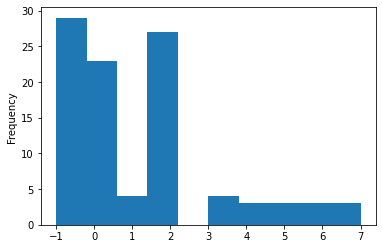

In [ ]:
df[COL_VENUE_CLS]=df[COL_VENUE_CLS].astype(int)
df[COL_VENUE_CLS].plot(kind='hist')

We see that, besides outlier class -1, the two most densely populated clusters are 0 and 2, which are both in the center of town. Let's put these into their own separate data frames.

In [ ]:
df_0 = df.loc[df[COL_VENUE_CLS] == 0]
df_2 = df.loc[df[COL_VENUE_CLS] == 2]

print('df_0:', df_0.shape)
print('df_2:', df_2.shape)

df_0: (23, 6)
df_2: (27, 6)


We have identified the two largest venue clusters in Bournemouth. Now, we want to analyse the venue distribution within each cluster. We create two bar charts showing venue frequency per clusters 0 and 2.

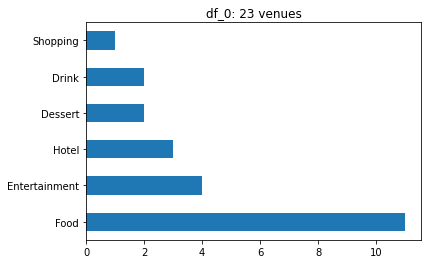

In [ ]:
df_0[COL_VENUE_GRP].value_counts().plot(kind='barh', title='df_0: {} venues'.format(df_0.shape[0]))

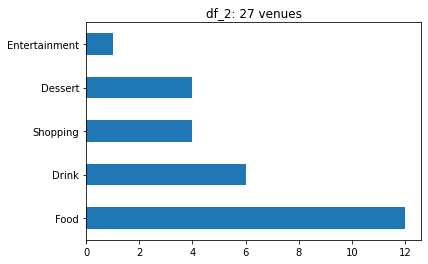

In [ ]:
df_2[COL_VENUE_GRP].value_counts().plot(kind='barh', title='df_2: {} venues'.format(df_2.shape[0]))

We see that, of the two clusters, cluster 0 has fewer Food venues, which is desirable, but is only marginally lower than the Food venues in 2. However, cluster 2 has a more non-Food venues than 0.

Next, we split the venues into 9 groups based on the clusters they were assigned to.

In [ ]:
df[COL_VENUE_CLS]=df[COL_VENUE_CLS].astype(str)
df_grpoutlier = df[df[COL_VENUE_CLS] == '-1']
df_group0 = df[df[COL_VENUE_CLS] == '0']
df_group1 = df[df[COL_VENUE_CLS] == '1']
df_group2 = df[df[COL_VENUE_CLS] == '2']
df_group3 = df[df[COL_VENUE_CLS] == '3']
df_group4 = df[df[COL_VENUE_CLS] == '4']
df_group5 = df[df[COL_VENUE_CLS] == '5']
df_group6 = df[df[COL_VENUE_CLS] == '6']
df_group7 = df[df[COL_VENUE_CLS] == '7']


Lastly, we define our own function to create the search map.

In [ ]:
venue = str(input('Venue Types to choose from: Drink, Entetainment, Food, Transportation, Hotel, Shopping, Dessert ')).upper()

def generate_map_for_search(df, lat, lng, zoom, col_lat, col_lng,col_venue_type=venue,
                 col_popup=COL_VENUE_GRP, popup_colors=False, def_color='red',
                 tiles='cartodbpositron'):
  
  #changing the input from both of lowercase and uppercase to all uppercase and make the result global 
  def switch_to_upper(venue):
    global col_venue_type
    col_venue_type = venue.upper()
  switch_to_upper(venue)

#we calculate the distance of each cluster to our randomly generated coordinates at Bournemouth using the longitudes and latitudes
#then we use the nearest cluster to the randomly generated coordinates as the returned search result, which is based on the input  
#of the user.
  distance = [math.sqrt((df_grpoutlier[COL_VENUE_LAT].mean()-lat)**2+(df_grpoutlier[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group0[COL_VENUE_LAT].mean()-lat)**2+(df_group0[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group1[COL_VENUE_LAT].mean()-lat)**2+(df_group1[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group2[COL_VENUE_LAT].mean()-lat)**2+(df_group2[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group3[COL_VENUE_LAT].mean()-lat)**2+(df_group3[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group4[COL_VENUE_LAT].mean()-lat)**2+(df_group4[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group5[COL_VENUE_LAT].mean()-lat)**2+(df_group5[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group6[COL_VENUE_LAT].mean()-lat)**2+(df_group6[COL_VENUE_LNG].mean()-lng)**2),
          math.sqrt((df_group7[COL_VENUE_LAT].mean()-lat)**2+(df_group7[COL_VENUE_LNG].mean()-lng)**2)]
  n = distance.index(min(distance))
  if n == 0:
            df = df_grpoutlier
  elif n == 1:
            df = df_group0
  elif n == 2:
            df = df_group1
  elif n == 3:
            df = df_group2
  elif n == 4:
            df = df_group3
  elif n == 5:
            df = df_group4
  elif n == 6:
            df = df_group5
  elif n == 7:
            df = df_group6
  else:
            df = df_group7
  df = df[df[COL_VENUE_GRP] == globals()[col_venue_type]]

  folmap = folium.Map(location=[lat, lng], zoom_start=zoom, tiles=tiles)
    
  popup = list(df[col_popup].unique())
    
  if popup_colors:
        colors = make_color_palette(len(popup))
    
  for index, row in df.iterrows():
        folium.CircleMarker(
            location=(row[col_lat], row[col_lng]),
            radius=6,
            popup=row[col_popup] if col_popup is not None else '',
            fill=True,
            tooltip=row[COL_VENUE_NAME],
            color=colors[popup.index(row[col_popup])] if popup_colors else def_color,
            fill_opacity=0.6
            ).add_to(folmap)
  #We add in a different type of marker here to show the location of the user on the map
  folium.Marker(
      location=(lat,lng),
  ).add_to(folmap)
    
  return folmap

#we use the random.uniform method here to generate the random location at Bournemouth
generate_map_for_search(df, random.uniform(50.71979486465741, 50.72702513291062), random.uniform(-1.8960956440425136, -1.8588841918312096), ZOOM, COL_VENUE_LAT, COL_VENUE_LNG)


Venue Types to choose from: Drink, Entetainment, Food, Transportation, Hotel, Shopping, Dessert drink
